In [1]:
(import-as "picseg" 'pic)

(pic)

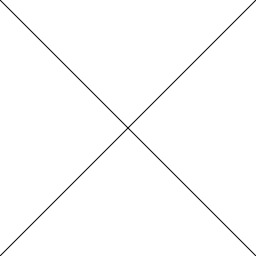

In [2]:
(pic.clear)
(pic.draw_line 0.0 0.0 1.0 1.0)
(pic.draw_line 0.0 1.0 1.0 0.0)
;(pic.draw_line 0.0 0.5 1.0 0.5)
;(pic.draw_line 0.0 1.0 1.0 1.0)
(pic.update)

In [3]:
; 線分からwaveペインタの作成
(define (segments->painter segment-list)
  (lambda (frame)
    (for-each
     (lambda (segment)
       (draw-line ((frame-coord-map frame) (start-segment segment))
                  ((frame-coord-map frame) (end-segment segment))
                  )
       )
     segment-list))
  )


In [4]:
(for-each (lambda (x)(display x)) (list 1 2 3))

123

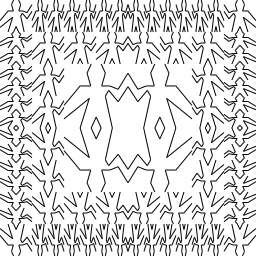

In [4]:
;;SICPの 2.2.4 図形言語
;;図形言語を実装する。絵を描画する手続きを"painter"として、schemeのプリミティブな関すとして実装する
;;で再帰的なパターンなんかを描画して楽しみつつ、抽象化の力を勉強していく。みたいな感じかな

(define (right-split painter n)
  (if (= n 0)
      painter
      (let ((smaller (right-split painter (- n 1))))
        (beside painter (below smaller smaller)))))

(define (corner-split painter n)
  (if (= n 0)
      painter
      (let ((up (up-split painter (- n 1)))
            (right (right-split painter (- n 1))))
        (let ((top-left (beside up up))
              (bottom-right (below right right))
              (corner (corner-split painter (- n 1))))
          (beside (below painter top-left)
                  (below bottom-right corner))))))

(define (square-limit painter n)
  (let ((quarter (corner-split painter n)))
    (let ((half (beside (flip-horiz quarter) quarter)))
      (below (flip-vert half) half))))

;;** 問2.44 up-splitを実装
;;突然問題が出てきた、読者のテンションを保つため？

(define (up-split painter n)
  (if (= n 0)
      painter
      (let ((smaller (up-split painter (- n 1))))
        (below painter (beside smaller smaller)))))

;;** 高階演算
;;手続きpainterを引数として取る、高階関数でパターンを作る

(define (square-of-four tl tr bl br)
  (lambda (painter)
    (let ((top (beside (tl painter) (tr painter)))
          (bottom (beside (bl painter) (br painter))))
      (below bottom top))))

(define (flipped-pairs painter)
  (let ((combine4 (square-of-four identity flip-vert
                                  identity flip-vert)))
    (combine4 painter)))

(define (square-limit painter n)
  (let ((combine4 (square-of-four flip-horiz identity
                                  rotate180 flip-vert)))
    (combine4 (corner-split painter n))))

;;** 問2.45 up-splitを再実装
;;right-splitとup-splitを抽象化する

(define (split a b)
  (lambda (painter n)
    (if (= n 0)
        painter
        (let ((smaller ((split a b) painter (- n 1))))
          (a painter (b smaller smaller))))))

;;(define right-split (split beside below))
;;(define up-split (split below beside))


;;** フレーム
;;原点からのベクタとx & yの三つのベクタでframeを表現する。
;;vector自体は抽象化するので実装は気にしない、というので感心した、そうかーそうだよな。

;;** 問 2.46 vectorを実装する

(define (frame-coord-map frame)
  (lambda (v)
    (add-vect
     (origin-frame frame)
     (add-vect (scale-vect (xcor-vect v)
                           (edge1-frame frame))
               (scale-vect (ycor-vect v)
                           (edge2-frame frame))))))

(define (make-vect x y)
  (cons x y))

(define (xcor-vect v)
  (car v))

(define (ycor-vect v)
  (cdr v))

(define (add-vect v1 v2)
  (make-vect (+ (xcor-vect v1)
                (xcor-vect v2))
             (+ (ycor-vect v1)
                (ycor-vect v2))))

(define (sub-vect v1 v2)
  (make-vect (- (xcor-vect v1)
                (xcor-vect v2))
             (- (ycor-vect v1)
                (ycor-vect v2))))

(define (scale-vect s v)
  (make-vect (* s (xcor-vect v))
             (* s (ycor-vect v))))


;;** 問 2.47 2パターンのmake-frameに対し選択子を実装
(define (make-frame origin edge1 edge2)
  (list origin edge1 edge2))

(define (origin-frame frame)
  (car frame))
(define (edge1-frame frame)
  (cadr frame))
(define (edge2-frame frame)
  (caddr frame))

(define (make-frame origin edge1 edge2)
  (cons origin (cons edge1 edge2)))
(define (origin-frame frame)
  (car frame))
(define (edge1-frame frame)
  (cadr frame))
(define (edge2-frame frame)
  (cddr frame))


;;** ペインター
;(define (for-each f list)
;  (map (lambda (n)(f n)) list))

(define (segments->painter segment-list)
  (lambda (frame)
    (for-each
     (lambda (segment)
       (draw-line
        ((frame-coord-map frame) (start-segment segment))
        ((frame-coord-map frame) (end-segment segment))))
     segment-list)))

;;** 2.48 segmentの実装
(define (make-segment v1 v2)
  (cons v1 v2))
(define (start-segment seg)
  (car seg))
(define (end-segment seg)
  (cdr seg))

;;** 2.49 painterの実装
(define (make-segment-list vect-list)
  (map
   (lambda (x)
     (make-segment (car x) (cadr x)))
   vect-list))

(define outline-painter
  (lambda (frame)
    ((segments->painter
      (make-segment-list
       (list
        (list (make-vect 0 0) (make-vect 0 1))
        (list (make-vect 0 1) (make-vect 1 1))
        (list (make-vect 1 1) (make-vect 1 0))
        (list (make-vect 1 0) (make-vect 0 0))))) frame)))

(define x-painter
  (lambda (frame)
    ((segments->painter
      (make-segment-list
       (list
        (list (make-vect 0 0) (make-vect 1 1))
        (list (make-vect 1 0) (make-vect 0 1))))) frame)))

(define diamond-painter
  (lambda (frame)
    ((segments->painter
      (make-segment-list
       (list
        (list (make-vect 0 0.5) (make-vect 0.5 0))
        (list (make-vect 0.5 0) (make-vect 1 0.5))
        (list (make-vect 1 0.5) (make-vect 0.5 1))
        (list (make-vect 0.5 1) (make-vect 0 0.5))))) frame)))

(define wave-painter
  (lambda (frame)
    ((segments->painter
      (list (make-segment (make-vect 0.000 0.645) (make-vect 0.154 0.411))
            (make-segment (make-vect 0.154 0.411) (make-vect 0.302 0.588))
            (make-segment (make-vect 0.302 0.588) (make-vect 0.354 0.497))
            (make-segment (make-vect 0.354 0.497) (make-vect 0.245 0.000))
            (make-segment (make-vect 0.419 0.000) (make-vect 0.497 0.171))
            (make-segment (make-vect 0.497 0.171) (make-vect 0.575 0.000))
            (make-segment (make-vect 0.748 0.000) (make-vect 0.605 0.462))
            (make-segment (make-vect 0.605 0.462) (make-vect 1.000 0.142))
            (make-segment (make-vect 1.000 0.354) (make-vect 0.748 0.657))
            (make-segment (make-vect 0.748 0.657) (make-vect 0.582 0.657))
            (make-segment (make-vect 0.582 0.657) (make-vect 0.640 0.857))
            (make-segment (make-vect 0.640 0.857) (make-vect 0.575 1.000))
            (make-segment (make-vect 0.419 1.000) (make-vect 0.354 0.857))
            (make-segment (make-vect 0.354 0.857) (make-vect 0.411 0.657))
            (make-segment (make-vect 0.411 0.657) (make-vect 0.285 0.657))
            (make-segment (make-vect 0.285 0.657) (make-vect 0.154 0.605))
            (make-segment (make-vect 0.154 0.605) (make-vect 0.000 0.857)))) frame)))


;;** ペインタ変換と組み合わせ
(define (transform-painter painter origin corner1 corner2)
  (lambda (frame)
    (let ((m (frame-coord-map frame)))
      (let ((new-origin (m origin)))
        (painter
         (make-frame new-origin
                     (sub-vect (m corner1) new-origin)
                     (sub-vect (m corner2) new-origin)))))))

(define (flip-vert painter)
  (transform-painter painter
                     (make-vect 0.0 1.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 0.0)))

(define (shrink-to-upper-right painter)
  (transform-painter painter
                     (make-vect 0.5 0.5)
                     (make-vect 1.0 0.5)
                     (make-vect 0.5 1.0)))

(define (rotate90 painter)
  (transform-painter painter
                     (make-vect 1.0 0.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 1.0)))

(define (squash-inwards painter)
  (transform-painter painter
                     (make-vect 0.0 0.0)
                     (make-vect 0.65 0.35)
                     (make-vect 0.35 0.65)))

(define (beside painter1 painter2)
  (let ((split-point (make-vect 0.5 0.0)))
    (let ((paint-left
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              split-point
                              (make-vect 0.0 1.0)))
          (paint-right
           (transform-painter painter2
                              split-point
                              (make-vect 1.0 0.0)
                              (make-vect 0.5 1.0))))
      (lambda (frame)
        (paint-left frame)
        (paint-right frame)))))

;;** 2.50 frame変換手続きをいくつか実装
(define (flip-horiz painter)
  (transform-painter painter
                     (make-vect 1.0 0.0)
                     (make-vect 0.0 0.0)
                     (make-vect 1.0 1.0)))

(define (rotate180 painter)
  (transform-painter painter
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 1.0)
                     (make-vect 1.0 0.0)))

(define (rotate270 painter)
  (transform-painter painter
                     (make-vect 0.0 1.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 0.0)))

(define (below painter1 painter2)
  (let ((split-point (make-vect 0.0 0.5)))
    (let ((paint-below
           (transform-painter painter1
                              (make-vect 0.0 0.0)
                              (make-vect 1.0 0.0)
                              split-point))
          (paint-above
           (transform-painter painter2
                              split-point
                              (make-vect 1.0 0.5)
                              (make-vect 0.0 1.0))))
      (lambda (frame)
        (paint-below frame)
        (paint-above frame)))))

(define (identity x) x)

(import-as "pic_line" 'pic)

(define (draw-line v1 v2)
  (let ((start-x (xcor-vect v1))
        (start-y (ycor-vect v1))
        (end-x (xcor-vect v2))
        (end-y (ycor-vect v2)))
    (pic.draw_line start-x start-y end-x end-y)
    ;(display start-x)
    ;(display start-y)
    ;(display end-x)
    ;(display end-y)
    ;(newline)
    )
  )

(define (updata-canvas n)
  (let ((current-frame (make-frame
                        (make-vect 0 0)
                        (make-vect 1 0)
                        (make-vect 0 1))))
    ((square-limit wave-painter n) current-frame)
    )
  )

(pic.clear)
(updata-canvas 2)
(pic.update)


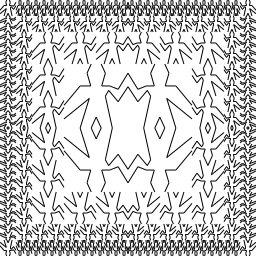

In [5]:
(pic.clear)
(updata-canvas 3)
(pic.update)

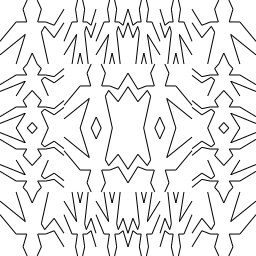

In [6]:
(pic.clear)
(updata-canvas 1)
(pic.update)

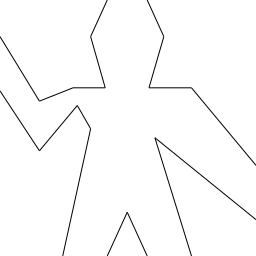

In [7]:
(pic.clear)
(let ((current-frame (make-frame
                        (make-vect 0 0)
                        (make-vect 1 0)
                        (make-vect 0 1))))
    (wave-painter current-frame)
    )
(pic.update)

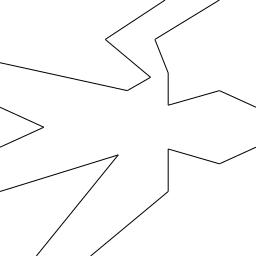

In [8]:
(pic.clear)
(let ((current-frame (make-frame
                        (make-vect 0 1)
                        (make-vect 0 -1)
                        (make-vect 1 0))))
    (wave-painter current-frame)
    )
(pic.update)

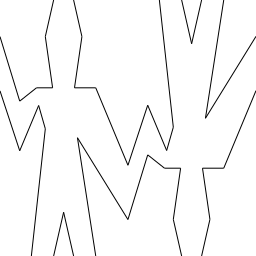

In [17]:
(define (rotate90 painter)
  (transform-painter painter
                     ;(make-vect 1.0 0.0)
                     ;(make-vect 1.0 1.0)
                     ;(make-vect 0.0 1.0)))
                     (make-vect 0.0 0.0)
                     (make-vect 1.0 0.0)
                     (make-vect 0.0 1.0)))


(pic.clear)
(let ((current-frame (make-frame
                        (make-vect 0 0)
                        (make-vect 1 0)
                        (make-vect 0 1))))
    ((beside wave-painter (flip-vert wave-painter)) current-frame)
    )
(pic.update)

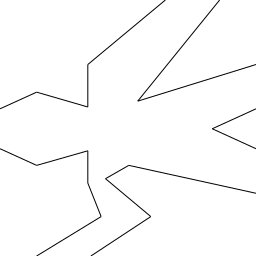

In [27]:
;(define (rotate90 painter)
;  (transform-painter painter
;                     (make-vect 1.0 0.0)
;                     (make-vect 0.0 1.0)
;                     (make-vect 0.0 1.0)))
(define (rotate90 painter)
  (transform-painter painter
                     (make-vect 1.0 0.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 0.0)))

(pic.clear)
(let ((current-frame (make-frame
                        (make-vect 0 0)
                        (make-vect 1 0)
                        (make-vect 0 1))))
    ((rotate90 wave-painter) current-frame)
    )
(pic.update)

In [18]:
(define frame0 (make-frame
                        (make-vect 0 0)
                        (make-vect 1 0)
                        (make-vect 0 1)))

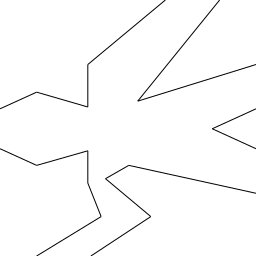

In [24]:
(define (rotate90 painter)
  (transform-painter painter
                     (make-vect 1.0 0.0)
                     (make-vect 1.0 1.0)
                     (make-vect 0.0 0.0)))

(pic.clear)
((rotate90 wave-painter) frame0)
(pic.update)

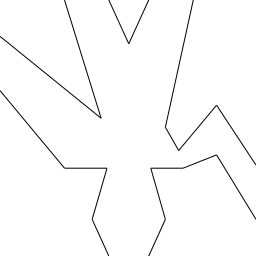

In [28]:
(pic.clear)
((rotate180 wave-painter) frame0)
(pic.update)

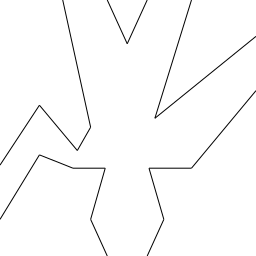

In [29]:
(pic.clear)
((rotate270 wave-painter) frame0)
(pic.update)